In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.cross_validation as CV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier

/home/krikunovalexey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
RANDOM_STATE = 1512

# Load and preprocess the data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
X_unscaled, y_ = df[df.columns[:-1]], df['y']
min_max_scaler = preprocessing.StandardScaler()
X_ = min_max_scaler.fit_transform(X_unscaled)
df2 = pd.DataFrame(X_, columns=df.columns[:-1])

In [5]:
y_ = y_.as_matrix().reshape((1105, 1))

In [6]:
df2.describe()

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1514,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523
count,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,...,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03,1.105000e+03
mean,1.434247e-16,-9.053592e-16,-1.615098e-16,-4.272600e-16,7.192186e-15,5.229603e-17,-3.269883e-16,-2.676592e-16,3.262348e-16,3.760692e-16,...,5.191423e-16,-9.203297e-17,2.257872e-16,-4.812704e-16,-4.124403e-17,-8.129244e-16,-7.421916e-16,-4.001324e-16,-1.838650e-17,2.538442e-16
std,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,...,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00
min,-7.053718e-01,-1.837649e+00,-3.226550e+00,-2.378447e+00,-3.158620e+00,-5.544192e-01,-1.948138e+00,-1.909228e+00,-1.570259e+00,-1.751417e+00,...,-4.435228e+00,-2.918446e+00,-4.848142e+00,-5.770166e+00,-7.356416e+00,-6.464318e+00,-5.337989e+00,-4.505849e+00,-3.971525e+00,-3.410555e+00
25%,-3.578951e-01,-7.012435e-01,-7.265741e-01,-7.475250e-01,-5.990244e-01,-2.979976e-01,-4.970281e-01,-7.061821e-01,-7.198065e-01,-7.223001e-01,...,-5.623194e-01,-3.773092e-01,-5.197094e-01,-4.874340e-01,-4.880606e-01,-4.457424e-01,-4.548227e-01,-4.314880e-01,-4.491226e-01,-4.114749e-01
50%,-1.904229e-01,-1.886059e-01,-2.454100e-02,-1.386394e-01,-1.007275e-01,-1.715992e-01,-1.819737e-01,-1.826980e-01,-2.213800e-01,-1.924221e-01,...,5.117395e-02,2.037167e-01,6.799576e-02,1.233569e-01,1.535134e-01,1.609785e-01,1.643235e-01,1.825452e-01,1.543961e-01,1.826317e-01
75%,6.162547e-02,5.798737e-01,7.457282e-01,5.972684e-01,4.515874e-01,1.674121e-02,3.008929e-01,5.777789e-01,4.986620e-01,5.497978e-01,...,6.333252e-01,6.669497e-01,6.324632e-01,6.449090e-01,6.072456e-01,5.952042e-01,6.136688e-01,6.290139e-01,6.605855e-01,6.561198e-01
max,1.471719e+01,6.184554e+00,3.944963e+00,5.712028e+00,4.780912e+00,1.529942e+01,1.154528e+01,5.872578e+00,6.058919e+00,6.279296e+00,...,2.564417e+00,2.681901e+00,2.640261e+00,2.658611e+00,2.776772e+00,2.811386e+00,2.881865e+00,2.803789e+00,2.813856e+00,2.767153e+00


# ANN

## Helper functions and classes

In [8]:
def linear_activation(vector, weights, bias):
    return tf.matmul(vector, weights) + bias

In [9]:
class BatchGenerator():
    def __init__(self, X, y, batch_size):
        self.X = X
        self.Y = y
        self.batch_size = batch_size
        self.n_batch = (len(X) // batch_size)
        self.index = 0

    def get_batch(self):
        batch_range = range(self.index, (self.index+1)*self.batch_size)
        if self.index == self.n_batch:
            batch_range = range(self.index, len(self.X))
        self.index += 1

        return self.X[batch_range], self.Y[batch_range]

    def resetIndex(self):
        self.index = 0

### NN layers
As far this is ad-hoc solution for test task layer composing fuctions includes code for regularization

In [10]:
class One2OneLayer(object):
    def __init__(self, input_layer, weight_init=None):
        input_size = input_layer.get_shape()[1].value

        o2o_weights = tf.Variable(tf.random_normal([input_size]))
        o2o_output = input_layer * o2o_weights

        self.output = o2o_output
        self.input = input_layer
        self.output = o2o_output
        self.weights = o2o_weights
    
class DenseLayer():
    def __init__(self, input_layer, layer_size, activation):
        input_size = input_layer.get_shape()[1].value
        
        low=-np.sqrt(6. / (input_size + layer_size))
        high=np.sqrt(6. / (input_size + layer_size))
        
        weights = tf.Variable(tf.random_uniform([input_size, layer_size], 
                                               minval=low, maxval=high))
        bias = tf.Variable(tf.random_uniform([layer_size], 
                                             minval=low, maxval=high))

        z = linear_activation(input_layer, weights, bias)
        output = activation(z)
        
        self.input = input_layer
        self.bias = bias
        self.output = output
        self.weights = weights
        
class SoftmaxLayer():
    """
        This class describes the output layer of NN
        with softmax loss function
    """
    def __init__(self, input_layer, layer_size, y):
        input_size = input_layer.get_shape()[1].value

        low=-np.sqrt(6. / (input_size + layer_size))
        high=np.sqrt(6. / (input_size + layer_size))
        
        weights = tf.Variable(tf.random_uniform([input_size, layer_size], 
                                               minval=low, maxval=high))
        bias = tf.Variable(tf.random_uniform([layer_size], 
                                             minval=low, maxval=high))

        z = linear_activation(input_layer, weights, bias)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=z))

        # Evaluate model
        correct_predictions = tf.equal(tf.argmax(z, 1), tf.argmax(y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        
        self.input = input_layer
        self.bias = bias
        self.output = z
        self.weights = weights
        
        self.cost = cost
        self.y = y


In [11]:
class DeepFeatureSelectionNN():
    def __init__(self, X, Y, layers_dimentions=100, n_layers=5, activation=tf.nn.sigmoid,
                 lambda1=0.01, lambda2=1.0, alpha1=0.001, alpha2=1.0):
        self.X = X
        self.Y = Y
    
        #Calculate shapes
        n_sample, n_feat = X.shape
        n_classes =  Y.shape[1]
        if n_classes == 1:
            enc = OneHotEncoder()
            self.Y = enc.fit_transform(Y).todense()
            n_classes = self.Y.shape[1]
    
        #Init input layers
        self.input_X = tf.placeholder("float32", shape=(None, n_feat), name="input_X")
        self.input_y = tf.placeholder("float32", shape=(None, n_classes), name="input_Y")
        
        #Add one2one, dense and softmax layers
        self.hidden_layers = []
        self.hidden_layers.append(One2OneLayer(self.input_X))
        
        dims = []
        if type(layers_dimentions) != list:
            dims = [layers_dimentions for k in range(n_layers)]
        else:
            dims = layers_dimentions
        
        for layer_size in dims:
            input_hidden = self.hidden_layers[-1].output if self.hidden_layers else self.input_X
            self.hidden_layers.append(DenseLayer(input_hidden, layer_size, activation=activation))
            
        self.output_layer = SoftmaxLayer(self.hidden_layers[-1].output, n_classes, self.input_y)
        self.hidden_layers.append(self.output_layer)
        
        #Collect weights from layers
        w = self.hidden_layers[0].weights
        sqr_frob_norm = [tf.norm(l.weights, 'euclidean') ** 2 for l in self.hidden_layers[1:]]
        l1_norm = [tf.norm(l.weights, 1) for l in self.hidden_layers[1:]]
        
        #Precalculate regularization terms
        regularization1 = lambda1*((1.0-lambda2) * 0.5 * tf.norm(w) ** 2 + lambda2 * tf.norm(w, 1))
        regularization2 = alpha1*((1.0-alpha2) * 0.5 * tf.add_n(sqr_frob_norm) +  lambda1 * tf.add_n(l1_norm))
        
        #Calculate cost function
        self.cost = self.output_layer.cost + regularization1 + regularization2
    
    
    def train(self,lerning_rate=0.01, epochs=1000, batch_size=100, 
              verbose=True, print_step=100, random_state=441, fit_mode=False):
        
        if not fit_mode:
            X_train, X_test, Y_train, Y_test = CV.train_test_split(self.X, 
                                                                   self.Y, 
                                                                   random_state=random_state)
        else:
            X_train, X_test, Y_train, Y_test = self.X, self.X, self.Y, self.Y
        
        GDoptimizer = tf.train.AdamOptimizer(lerning_rate)\
                              .minimize(self.cost)
        
        self.accuracy = self.output_layer.accuracy
        
        s = tf.Session()
        self.s = s
        s.run(tf.global_variables_initializer())
        
        batch_generator = BatchGenerator(X_train, Y_train, batch_size)
        n_batch = batch_generator.n_batch
        
        self.losses, self.losses_test, self.train_accs, self.test_accs = [], [], [], []
        
        for i in range(epochs):
            batch_generator.resetIndex()
            for j in range(n_batch + 1):
                x_batch, y_batch = batch_generator.get_batch()
                s.run(GDoptimizer, feed_dict={self.input_X : x_batch, self.input_y: y_batch})

                
                
            self.train_accs.append(s.run(self.output_layer.accuracy,
                                         feed_dict={self.input_X: X_train, self.input_y: Y_train}))
            self.losses.append(s.run(self.cost,
                                        feed_dict={self.input_X: X_train, self.input_y: Y_train}))
            
            if not fit_mode:
                self.losses_test.append(s.run(self.cost,
                                               feed_dict={self.input_X: X_test, self.input_y: Y_test}))
                self.test_accs.append(s.run(self.output_layer.accuracy,
                                               feed_dict={self.input_X: X_test, self.input_y: Y_test}))

            if verbose and i % print_step == 0:
                print('epoch {}: loss = {}'.format(i, self.losses[-1]))
                print("Train accuracy:", self.train_accs[-1])
                print("train auc:", roc_auc_score(Y_train, s.run(self.output_layer.output, 
                                                                 {self.input_X: X_train})))
                if not fit_mode:
                    print('loss_test = {}'.format(self.losses_test[-1]))
                    print("Test accuracy:", self.test_accs[-1])
                    print("test auc:", roc_auc_score(Y_test, s.run(self.output_layer.output, 
                                                                   {self.input_X: X_test})))
        
        self.selected_ws = s.run(self.hidden_layers[0].weights)
        if verbose:
            print("Final train accuracy:", self.train_accs[-1])
            if not fit_mode:
                print("Final test accuracy:", self.test_accs[-1])

In [12]:
dfs_nn = DeepFeatureSelectionNN(X_, y_, [512, 128], activation=tf.nn.tanh)

In [14]:
%%time
dfs_nn.train(0.01, 200, 100, print_step=20, random_state=RANDOM_STATE, fit_mode=False)

epoch 0: loss = 11.554086685180664
Train accuracy: 0.8333333
train auc: 0.8637562406566439
loss_test = 11.699357032775879
Test accuracy: 0.7906137
test auc: 0.8022763900080581
epoch 20: loss = 0.7101830840110779
Train accuracy: 0.9625604
train auc: 0.9224501452627422
loss_test = 1.1023000478744507
Test accuracy: 0.85559565
test auc: 0.8365229653505237
epoch 40: loss = 0.21674512326717377
Train accuracy: 0.99396133
train auc: 0.9920211265619271
loss_test = 0.8384432792663574
Test accuracy: 0.86281586
test auc: 0.8700980392156863
epoch 60: loss = 0.15350039303302765
Train accuracy: 0.9987923
train auc: 0.9971652610498406
loss_test = 0.8293686509132385
Test accuracy: 0.8700361
test auc: 0.8688557614826753
epoch 80: loss = 0.14629358053207397
Train accuracy: 0.9975845
train auc: 0.9986460948297746
loss_test = 1.019761323928833
Test accuracy: 0.87725633
test auc: 0.8736234219715284
epoch 100: loss = 0.1091199666261673
Train accuracy: 0.9987923
train auc: 0.9994323470510253
loss_test = 0.985

Text(0,0.5,'LOSS')

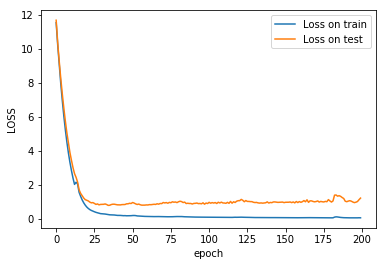

In [15]:
h1, = plt.plot(dfs_nn.losses, label="Loss on train")
h2, = plt.plot(dfs_nn.losses_test, label="Loss on test")

plt.legend(handles=[h1, h2])

plt.xlabel("epoch")
plt.ylabel("LOSS")

Из графика выше видно, что довольно быстро начинается переобучения модели, поэтому лучше остановиться заранее или добавить регуляризацию. Разумеется, выбор количества эпох и борьба с оверфитингом должно вестись не просто выборомточки визуально на граффике, но в данном случае у меня уже не хватило времени провести полноценный анализ.

Далее запускаем обучение модели с параметром fit_mode=True, что говорит алгортму использовать всю выборку, не разбивая её на тренировочную и валидирующую.

In [16]:
%%time
dfs_nn.train(0.01, 25, 100, print_step=5, random_state=RANDOM_STATE, fit_mode=True)

epoch 0: loss = 11.672040939331055
Train accuracy: 0.7683258
train auc: 0.8867832027325698
epoch 5: loss = 4.952267646789551
Train accuracy: 0.99366516
train auc: 0.9986437613019892
epoch 10: loss = 1.7416493892669678
Train accuracy: 0.9918552
train auc: 0.9989230460116536
epoch 15: loss = 0.732871413230896
Train accuracy: 0.9719457
train auc: 0.9689993972272454
epoch 20: loss = 0.4240298271179199
Train accuracy: 0.9755656
train auc: 0.9898151496885674
Final train accuracy: 0.9809955
CPU times: user 1min 23s, sys: 9.02 s, total: 1min 32s
Wall time: 18.2 s


# Evaluation

### Find feature importaince using different methods

In [19]:
y = y_.ravel()

In [20]:
rf_clf = RandomForestClassifier(n_jobs=2, random_state=RANDOM_STATE)
lgbm_clf = LGBMClassifier(random_state=RANDOM_STATE)

rf_clf.fit(X_, y);
lgbm_clf.fit(X_, y);

In [21]:
rf_feature_importances = list(zip(df2.columns[:-1], rf_clf.feature_importances_))
lgbm_feature_importances = list(zip(df2.columns[:-1],lgbm_clf.feature_importances_))
dfs_feature_importances = list(zip(df2.columns[:-1], dfs_nn.selected_ws))

rf_feature_importances.sort(key=lambda x: x[1], reverse=True)
lgbm_feature_importances.sort(key=lambda x: x[1], reverse=True)
dfs_feature_importances.sort(key=lambda x: x[1], reverse=True)

### Evaluation models

In [22]:
svc_clf = SVC(probability=True)
CV.cross_val_score(svc_clf, X_, y, cv=5, scoring='neg_log_loss').mean()

-0.2981868470640313

В следующем коде для каждого набора признаков, для модели дожен был осуществляться подбор гиперпараметров (закоменнтированный код), и вариант набора гиперпараметров должен был сохраняться вместе со значением целевой метрики. Но из-за того, что подобный подбор признаков занимал время, несовместимое с выполнением задания в срок, пришлось решить задачу частично и ограничиться кросс-валидацией.

Более того, в данном случае необходимо провести анализ результатов кросс-валидации, как минимум учитывать не только среднее, но и дисперсию результатов валидации на фолдах.

Так же, в общем случае, перебор нужно делать по числу признаков от 1 до максимального, чтобы убедиться, что выбор признаков не приводит к значительному ухудшению качества модели.

In [23]:
%%time

metrics = ['neg_log_loss', 'roc_auc']
mn, mx = 10, 300
feature_importances = [rf_feature_importances,
                      lgbm_feature_importances,
                      dfs_feature_importances]

#param_grid = [
#  {'C': [1, 10], 'kernel': ['linear']},
#  {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]

score_by_metric = {}
for metric in metrics:
    scores = []
    for fv in feature_importances:
        score = []
        for i in range(mn, mx):
            top = fv[:i]
            top_columns = [f[0] for f in top]
            X_top = df2[top_columns]
            
            m = CV.cross_val_score(svc_clf, X_top, y, cv=5, scoring=metric).mean()
            
            #grid_search = GridSearchCV(svc_clf, param_grid, scoring=metric, n_jobs=8, cv=4)
            #grid_search.fit(X_top, y_)
            #m = grid_search.best_score_ 
            
            score.append(m)
        scores.append(score)
    score_by_metric[metric] = scores

CPU times: user 1h 30min 49s, sys: 0 ns, total: 1h 30min 49s
Wall time: 1h 30min 49s


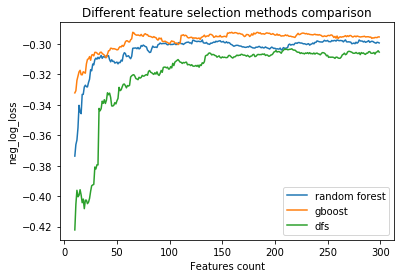

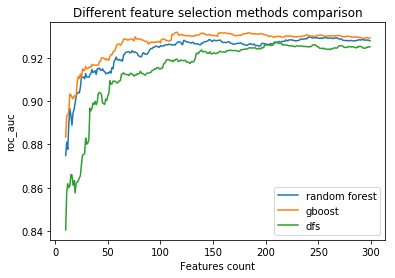

In [24]:
for metric in metrics:
    scores = score_by_metric[metric]
    labels = []
    for selection_method, score in zip(["random forest", "gboost", "dfs"], scores):
        label, = plt.plot(range(mn, mx), score, label = selection_method)
        labels.append(label)

    plt.title("Different feature selection methods comparison")
    plt.legend(handles=labels)
    plt.xlabel("Features count")
    plt.ylabel(metric)
    plt.show()

Правильно было бы так же и признаки ранжировать с использованием перебора гиперпараметров моделей отбора (Random Forest, GBoost, DFS). Но это очень затратная  по производительно операция заняла бы слишком много времени на выполнение.

In [25]:
roc_aucs = score_by_metric['roc_auc']

#Здесь происходит дублирование перебора осуществленного выше для построения граффиков, но так нагляднее
for selection_method, score in zip(["random forest", "gboost", "dfs"], roc_aucs):
    max_score = max(score)
    print("Maximum ROC AUC for {} feature selection is {:.3f} obtained on {} features".format(selection_method, 
                                                                                          max_score,
                                                                                          score.index(max_score) + mn))

Maximum ROC AUC for random forest feature selection is 0.930 obtained on 241 features
Maximum ROC AUC for gboost feature selection is 0.932 obtained on 116 features
Maximum ROC AUC for dfs feature selection is 0.927 obtained on 211 features


In [26]:
best_features_set = [f[0] for f in lgbm_feature_importances[:117]]
best_features_set

['feature-1460',
 'feature-1183',
 'feature-351',
 'feature-545',
 'feature-63',
 'feature-1025',
 'feature-602',
 'feature-973',
 'feature-214',
 'feature-358',
 'feature-889',
 'feature-226',
 'feature-382',
 'feature-369',
 'feature-584',
 'feature-687',
 'feature-868',
 'feature-101',
 'feature-460',
 'feature-881',
 'feature-1286',
 'feature-822',
 'feature-916',
 'feature-1013',
 'feature-62',
 'feature-464',
 'feature-588',
 'feature-596',
 'feature-660',
 'feature-1011',
 'feature-30',
 'feature-80',
 'feature-96',
 'feature-98',
 'feature-130',
 'feature-350',
 'feature-476',
 'feature-530',
 'feature-569',
 'feature-593',
 'feature-600',
 'feature-1001',
 'feature-1520',
 'feature-81',
 'feature-120',
 'feature-212',
 'feature-381',
 'feature-422',
 'feature-452',
 'feature-473',
 'feature-544',
 'feature-548',
 'feature-561',
 'feature-607',
 'feature-666',
 'feature-685',
 'feature-825',
 'feature-852',
 'feature-1339',
 'feature-52',
 'feature-104',
 'feature-115',
 'featu